In [1]:
!pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 4.1 MB/s eta 0:00:00


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Generating train split:   0%|          | 0/6940 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4615 [00:00<?, ? examples/s]

Dataset web_nlg downloaded and prepared to /root/.cache/huggingface/datasets/web_nlg/webnlg_challenge_2017/0.0.0/28ffb892f7f42450dd9558684aa43bcaf44b1b3bf0d77cb8d73534646af88dda. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Pretrain Epoch 1/2 - loss: 3.3853
Pretrain Epoch 2/2 - loss: 0.6591


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch 1/5 - loss: 0.8770
Epoch 2/5 - loss: 0.6842
Epoch 3/5 - loss: 0.5906
Epoch 4/5 - loss: 0.5131
Epoch 5/5 - loss: 0.4399


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 2753/2753 [00:00<00:00, 684180.77it/s]
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


Epoch 1 - BLEU: 0.4673, BLEU (Multiple References): 43.4721, CHR F++: 10.3486, CHR F++ (Multiple References): 64.8098


100%|██████████| 2753/2753 [00:00<00:00, 623483.74it/s]


Epoch 2 - BLEU: 0.4835, BLEU (Multiple References): 63.8943, CHR F++: 10.5909, CHR F++ (Multiple References): 62.0921


100%|██████████| 2753/2753 [00:00<00:00, 616723.76it/s]


Epoch 3 - BLEU: 0.4748, BLEU (Multiple References): 43.4721, CHR F++: 10.3599, CHR F++ (Multiple References): 64.8098


100%|██████████| 2753/2753 [00:00<00:00, 586823.14it/s]


Epoch 4 - BLEU: 0.4557, BLEU (Multiple References): 43.4721, CHR F++: 10.0000, CHR F++ (Multiple References): 64.8098


100%|██████████| 2753/2753 [00:00<00:00, 615343.40it/s]


Epoch 5 - BLEU: 0.4429, BLEU (Multiple References): 43.4721, CHR F++: 9.4246, CHR F++ (Multiple References): 64.8098


ValueError: x and y must have same first dimension, but have shapes (5,) and (2,)

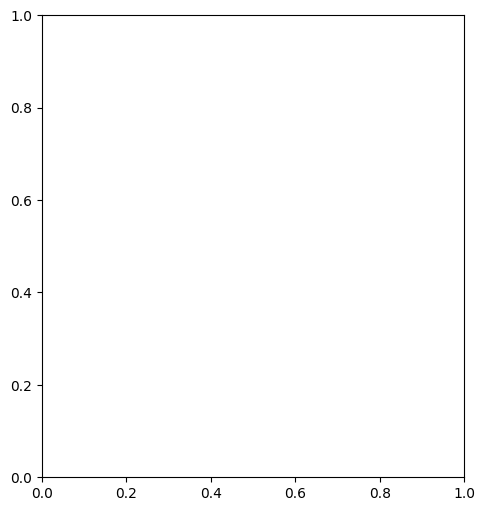

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from torch.nn.parallel import DataParallel
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sacrebleu import corpus_bleu, corpus_chrf
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)

tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-small")

model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
model = DataParallel(model)

new_tokens = ['<H>', '<R>', '<T>']
new_tokens_vocab = {}
new_tokens_vocab['additional_special_tokens'] = []
for idx, t in enumerate(new_tokens):
    new_tokens_vocab['additional_special_tokens'].append(t)
num_added_toks = tokenizer.add_special_tokens(new_tokens_vocab)

tokenizer.add_tokens("[MASK]")
tokenizer.mask_token = "[MASK]"
tokenizer.mask_token_id = tokenizer.convert_tokens_to_ids("[MASK]")

class WebNLGDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.prefix = "translate from Graph to Text: "

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        try:
            triples = item['original_triple_sets']['otriple_set']
            input_text = self.prefix
            for outer_list in triples:
                for triple in outer_list:
                    triple_txt = triple.split("|")
                    input_text += " <H> " + triple_txt[0] + " <R> " + triple_txt[1] + " <T> " + triple_txt[2]
        except (KeyError, IndexError):
            print("1")
            print(item['original_triple_sets']['otriple_set'])
            print(item['original_triple_sets']['otriple_set'][0])
            print(triples)
            input_text = self.prefix
        try:
            target_text = item['lex']['text'][0]
        except (KeyError, IndexError):
            print("2")
            print(item)
            target_text = ""
        input_ids = tokenizer.encode(input_text, return_tensors='pt', padding='max_length', max_length=128,
                                     truncation=True)
        target_ids = tokenizer.encode(target_text, return_tensors='pt', padding='max_length', max_length=128,
                                      truncation=True)
        return input_ids.squeeze(0), target_ids.squeeze(0)


MAX_INPUT_LENGTH = 128
MAX_TARGET_LENGTH = 128
tokenizer.model_max_length = MAX_INPUT_LENGTH
model.module.config.max_length = MAX_TARGET_LENGTH

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

dataset = load_dataset('web_nlg', 'webnlg_challenge_2017')['train']

pretrain_texts = []
for sample in dataset:
    try:
        text = sample['lex']['text'][0]
        pretrain_texts.append(text)
    except (KeyError, IndexError):
        continue

tokenized_inputs = tokenizer(pretrain_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
input_ids = tokenized_inputs['input_ids']
attention_mask = tokenized_inputs['attention_mask']

pretrain_data = torch.utils.data.TensorDataset(input_ids, attention_mask)

pretrain_loader = torch.utils.data.DataLoader(pretrain_data, batch_size=int(60), shuffle=True)

pretrain_optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
pretrain_criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

pretrain_epochs = 2
masking_prob = 0.15

if tokenizer.mask_token is None:
    tokenizer.add_tokens("[MASK]")
    tokenizer.mask_token = "[MASK]"
    tokenizer.mask_token_id = tokenizer.convert_tokens_to_ids("[MASK]")

pretrain_losses = []
for epoch in range(pretrain_epochs):
    running_loss = 0.0
    for inputs, attention_mask in pretrain_loader:
        inputs = inputs.to(device)
        attention_mask = attention_mask.to(device)
        batch_size, seq_length = inputs.shape
        mask = torch.rand(inputs.shape) < masking_prob
        masked_inputs = inputs.clone()
        masked_inputs[mask] = tokenizer.mask_token_id
        pretrain_optimizer.zero_grad()
        outputs = model(input_ids=masked_inputs, attention_mask=attention_mask, decoder_input_ids=inputs)
        masked_logits = outputs.logits[mask]
        masked_labels = inputs[mask]
        loss = pretrain_criterion(masked_logits.view(-1, masked_logits.size(-1)), masked_labels.view(-1))
        loss.backward()
        pretrain_optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(pretrain_data)
    print(f"Pretrain Epoch {epoch + 1}/{pretrain_epochs} - loss: {epoch_loss:.4f}")
    pretrain_losses.append(epoch_loss)

torch.save(model, 'pretrained_model_T5_flan_small')

train_data = WebNLGDataset(dataset)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

finetune_epochs = 5
finetune_losses = []
for epoch in range(finetune_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, labels=targets)
        loss = criterion(outputs.logits.view(-1, outputs.logits.size(-1)), targets.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_data)
    print(f"Epoch {epoch + 1}/{finetune_epochs} - loss: {epoch_loss:.4f}")
    finetune_losses.append(epoch_loss)
    torch.save(model, f'model_T5_flan_small_epoch{epoch + 1}')

validation_dataset = load_dataset('web_nlg', 'webnlg_challenge_2017')['test']
validation_dataset = [sample for sample in validation_dataset if sample['lex']['text']]
validation_data = WebNLGDataset(validation_dataset)

validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=False)

model.eval()

bleu_scores = []
chrf_scores = []
bleu_scores_multiple = []
chrf_scores_multiple = []
for epoch in range(finetune_epochs):
    model_path = f'model_T5_flan_small_epoch{epoch + 1}'
    model = torch.load(model_path)
    model.to(device)
    predictions = []
    references = []
    multiple_references = []
    for i in tqdm(range(len(validation_dataset))):
        multiple_references.append(validation_dataset[i]['lex']['text'])
    with torch.no_grad():
        for inputs, targets in validation_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model.module.generate(inputs, max_length=MAX_TARGET_LENGTH, num_beams=4)
            predicted_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            target_texts = tokenizer.batch_decode(targets, skip_special_tokens=True)
            predictions.extend(predicted_texts)
            references.extend(target_texts)
    bleu = corpus_bleu(predictions, references)
    chrf = corpus_chrf(predictions, references)
    bleu_multiple = corpus_bleu(predictions, multiple_references)
    chrf_multiple = corpus_chrf(predictions, multiple_references)
    bleu_scores.append(bleu.score)
    chrf_scores.append(chrf.score)
    bleu_scores_multiple.append(bleu_multiple.score)
    chrf_scores_multiple.append(chrf_multiple.score)
    print(f"Epoch {epoch + 1} - BLEU: {bleu.score:.4f}, BLEU (Multiple References): {bleu_multiple.score:.4f}, CHR F++: {chrf.score:.4f}, CHR F++ (Multiple References): {chrf_multiple.score:.4f}")

# Plotting the progress
epochs = range(1, finetune_epochs + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#plt.plot(epochs, pretrain_losses, label='Pretraining Loss')
plt.plot(epochs, finetune_losses, label='Fine-tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, bleu_scores, label='BLEU Score')
plt.plot(epochs, bleu_scores_multiple, label='BLEU Score (Multiple References)')
plt.plot(epochs, chrf_scores, label='CHR F++ Score')
plt.plot(epochs, chrf_scores_multiple, label='CHR F++ Score (Multiple References)')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Evaluation Scores')
plt.legend()

plt.tight_layout()
plt.show()


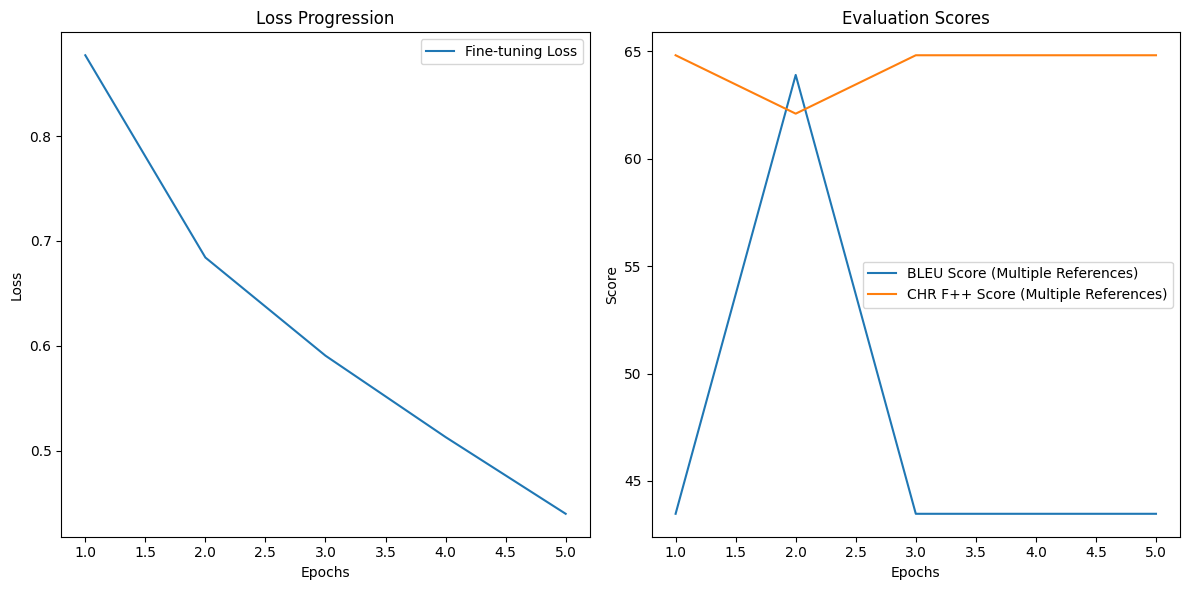

In [14]:
# Plotting the progress
epochs = range(1, finetune_epochs + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
#plt.plot(epochs, pretrain_losses, label='Pretraining Loss')
plt.plot(epochs, finetune_losses, label='Fine-tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Progression')
plt.legend()

plt.subplot(1, 2, 2)
#plt.plot(epochs, bleu_scores, label='BLEU Score')
plt.plot(epochs, bleu_scores_multiple, label='BLEU Score (Multiple References)')
#plt.plot(epochs, chrf_scores, label='CHR F++ Score')
plt.plot(epochs, chrf_scores_multiple, label='CHR F++ Score (Multiple References)')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Evaluation Scores')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Load the raw model
raw_model = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-small")
raw_model = DataParallel(raw_model)
raw_model.to(device)

# Load the pretrained model
pretrained_model = torch.load('pretrained_model_T5_flan_small')
pretrained_model.to(device)

# Set the models to evaluation mode
raw_model.eval()
pretrained_model.eval()

# Generate predictions for the validation dataset using the raw model
raw_predictions = []
raw_references = []
raw_multiple_references = []
for sample in validation_dataset:
    input_text = sample['input_text']
    target_texts = sample['target_texts']
    raw_outputs = raw_model.module.generate(tokenizer.encode(input_text, return_tensors='pt').to(device),
                                            max_length=MAX_TARGET_LENGTH, num_beams=4)
    raw_predicted_texts = tokenizer.batch_decode(raw_outputs, skip_special_tokens=True)
    raw_predictions.extend(raw_predicted_texts)
    raw_references.extend(target_texts)
    raw_multiple_references.append(target_texts)

# Calculate BLEU and CHR F++ scores for the raw model
raw_bleu = corpus_bleu(raw_predictions, raw_references)
raw_chrf = corpus_chrf(raw_predictions, raw_references)
raw_bleu_multiple = corpus_bleu(raw_predictions, raw_multiple_references)
raw_chrf_multiple = corpus_chrf(raw_predictions, raw_multiple_references)

# Generate predictions for the validation dataset using the pretrained model
pretrained_predictions = []
pretrained_references = []
pretrained_multiple_references = []
for sample in validation_dataset:
    input_text = sample['input_text']
    target_texts = sample['target_texts']
    pretrained_outputs = pretrained_model.module.generate(tokenizer.encode(input_text, return_tensors='pt').to(device),
                                                          max_length=MAX_TARGET_LENGTH, num_beams=4)
    pretrained_predicted_texts = tokenizer.batch_decode(pretrained_outputs, skip_special_tokens=True)
    pretrained_predictions.extend(pretrained_predicted_texts)
    pretrained_references.extend(target_texts)
    pretrained_multiple_references.append(target_texts)

# Calculate BLEU and CHR F++ scores for the pretrained model
pretrained_bleu = corpus_bleu(pretrained_predictions, pretrained_references)
pretrained_chrf = corpus_chrf(pretrained_predictions, pretrained_references)
pretrained_bleu_multiple = corpus_bleu(pretrained_predictions, pretrained_multiple_references)
pretrained_chrf_multiple = corpus_chrf(pretrained_predictions, pretrained_multiple_references)

# Print the scores
print("Raw Model:")
print(f"BLEU Score (References): {raw_bleu.score:.4f}")
print(f"BLEU Score (Multiple References): {raw_bleu_multiple.score:.4f}")
print(f"CHR F++ Score (References): {raw_chrf.score:.4f}")
print(f"CHR F++ Score (Multiple References): {raw_chrf_multiple.score:.4f}")

print("\nPretrained Model (Without Fine-tuning):")
print(f"BLEU Score (References): {pretrained_bleu.score:.4f}")
print(f"BLEU Score (Multiple References): {pretrained_bleu_multiple.score:.4f}")
print(f"CHR F++ Score (References): {pretrained_chrf.score:.4f}")
print(f"CHR F++ Score (Multiple References): {pretrained_chrf_multiple.score:.4f}")


In [7]:
i=70
print(validation_dataset[i])
print(validation_dataset[i]['original_triple_sets']['otriple_set'])
print(predictions[i])
print(multiple_references[i])

{'category': 'MeanOfTransportation', 'size': 1, 'eid': 'Id71', 'original_triple_sets': {'otriple_set': [['Alfa_Romeo_164 | relatedMeanOfTransportation | Lancia_Thema'], ['Alfa_Romeo_164 | related | Lancia_Thema']]}, 'modified_triple_sets': {'mtriple_set': [['Alfa_Romeo_164 | relatedMeanOfTransportation | Lancia_Thema']]}, 'shape': '', 'shape_type': '', 'lex': {'comment': ['good', 'good'], 'lid': ['Id1', 'Id2'], 'text': ['Alfa Romeo 164 and Lancia Thema are related types of transportation.', 'The related transport to the Alfa Romeo 164 is the Lancia Thema.'], 'lang': ['', '']}, 'test_category': 'testdata_unseen_with_lex', 'dbpedia_links': [], 'links': []}
[['Alfa_Romeo_164 | relatedMeanOfTransportation | Lancia_Thema'], ['Alfa_Romeo_164 | related | Lancia_Thema']]
The Alfa Romeo 164 is related to Lancia Thema.
['Alfa Romeo 164 and Lancia Thema are related types of transportation.', 'The related transport to the Alfa Romeo 164 is the Lancia Thema.']


In [11]:
validation_dataset[i]

{'category': 'Astronaut',
 'size': 7,
 'eid': 'Id971',
 'original_triple_sets': {'otriple_set': [['William_Anders | dateOfRet | "1969-09-01"^^xsd:date',
    'William_Anders | selection | 1963',
    'William_Anders | timeInSpace | "8820.0"^^<http://dbpedia.org/datatype/minute>',
    'William_Anders | birthDate | "1933-10-17"^^xsd:date',
    'William_Anders | occupation | Fighter_pilot',
    'William_Anders | birthPlace | British_Hong_Kong',
    'William_Anders | mission | Apollo_8']]},
 'modified_triple_sets': {'mtriple_set': [['William_Anders | dateOfRetirement | "1969-09-01"',
    'William_Anders | was selected by NASA | 1963',
    'William_Anders | timeInSpace | "8820.0"(minutes)',
    'William_Anders | birthDate | "1933-10-17"',
    'William_Anders | occupation | Fighter_pilot',
    'William_Anders | birthPlace | British_Hong_Kong',
    'William_Anders | was a crew member of | Apollo_8']]},
 'shape': '',
 'shape_type': '',
 'lex': {'comment': ['good', 'good', 'good'],
  'lid': ['Id1

In [13]:
i = 1861
print("Validation Sample:")
print(validation_dataset[i])
print("Original Triple Sets:")
print(validation_dataset[i]['original_triple_sets']['otriple_set'])

# Preprocess the input using WebNLGDataset class
input_data = [validation_dataset[i]]
input_dataset = WebNLGDataset(input_data)
input_loader = DataLoader(input_dataset, batch_size=1, shuffle=False)

for epoch in range(finetune_epochs):
    model_path = f'model_T5_flan_small_epoch{epoch + 1}'
    model = torch.load(model_path)
    model.to(device)
    for inputs, _ in input_loader:
        inputs = inputs.to(device)
        outputs = model.module.generate(inputs, max_length=MAX_TARGET_LENGTH, num_beams=4)
        predicted_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
        print(f"\nPrediction for Epoch {epoch + 1}:")
        print(predicted_text)
        print("Multiple References:")
        print(multiple_references[i])
        break  # Only process the first batch (single input)


Validation Sample:
{'category': 'Astronaut', 'size': 7, 'eid': 'Id971', 'original_triple_sets': {'otriple_set': [['William_Anders | dateOfRet | "1969-09-01"^^xsd:date', 'William_Anders | selection | 1963', 'William_Anders | timeInSpace | "8820.0"^^<http://dbpedia.org/datatype/minute>', 'William_Anders | birthDate | "1933-10-17"^^xsd:date', 'William_Anders | occupation | Fighter_pilot', 'William_Anders | birthPlace | British_Hong_Kong', 'William_Anders | mission | Apollo_8']]}, 'modified_triple_sets': {'mtriple_set': [['William_Anders | dateOfRetirement | "1969-09-01"', 'William_Anders | was selected by NASA | 1963', 'William_Anders | timeInSpace | "8820.0"(minutes)', 'William_Anders | birthDate | "1933-10-17"', 'William_Anders | occupation | Fighter_pilot', 'William_Anders | birthPlace | British_Hong_Kong', 'William_Anders | was a crew member of | Apollo_8']]}, 'shape': '', 'shape_type': '', 'lex': {'comment': ['good', 'good', 'good'], 'lid': ['Id1', 'Id2', 'Id3'], 'text': ['Test pilot